# Using Yelp Dataset To Improve My Business
In this notebook, we'll explore the various ways in which the Yelp Dataset can help a business improve.
Let's say we have a business, say, a pizza place, and we'd like know what can make it even better.
We'll use the following models:
1. Analyzing which business attributes (e.g., having a parking lot, accepting business card, allowing smoking and so on) are correlated with higher star rating.
2. Finding users that are most likely to enjoy our business and target them with ads, using collaborative filtering methods.
    

### Data Pre-processing
The Yelp dataset has some compound columns. For example, in the business table, there's a "categories" column which has multiple items in each cell (e.g., "Restaurant; Pizza; Fast Food"). For convenience, we'll split this column into multiple boolean columns that can be used as features. We'll do the same for the "attributes" column.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time


In [2]:
LINE_LIMIT = 50000

# Load data
business_data = []
line_count = 0
with open('yelp-dataset/business.json', 'r') as f:
    for line in f:
        if LINE_LIMIT is None or line_count < LINE_LIMIT:
            business_data.append(json.loads(line))
            line_count += 1
        else:
            break
business_df = pd.DataFrame.from_dict(business_data)
business_df = business_df.rename(columns = {'name': 'business_name'})
del business_data
print('Number of businesses loaded = ' + str(len(business_df)))

Number of businesses loaded = 50000


In [3]:
# Convert categories into multiple indicator columns
start_time = time.time()
business_df['categories_clean'] = business_df['categories'].map(lambda x: '|'.join(x))
categories_df = business_df.categories_clean.str.get_dummies(sep='|')
num_categories = len(categories_df.columns)
business_df = business_df.merge(categories_df, left_index=True, right_index=True)
business_df.drop(['categories', 'categories_clean'], axis=1, inplace=True)
categories_start_column = len(business_df.columns)
categories_end_column = categories_start_column + num_categories
end_time = time.time()
print('Finished splitting categories in ' + str(end_time - start_time) + ' seconds.')

Finished splitting categories in 83.61974906921387 seconds.


In [4]:
start_time = time.time()
# Convert attributes into multiple columns
business_df = business_df.join(pd.DataFrame(business_df['attributes'].to_dict()).T)
cols_to_split = ['BusinessParking', 'Ambience', 'BestNights', 'GoodForMeal', 'HairSpecializesIn', 'Music']
for col_to_split in cols_to_split:
    new_df = pd.DataFrame(business_df[col_to_split].to_dict()).T
    new_df.columns = [col_to_split + '_' + str(col) for col in new_df.columns]
    business_df = business_df.join(new_df)

# Remove redundant data to save memory
business_df.drop(['attributes'] + cols_to_split, axis=1, inplace=True)
business_df.drop(['postal_code', 'neighborhood'], axis=1, inplace=True)

# Further columns split
cols_to_split = ['AgesAllowed', 'Alcohol', 'BYOBCorkage', 'NoiseLevel', 'RestaurantsAttire', 'Smoking', 'WiFi']
new_cat = pd.concat([pd.get_dummies(business_df[col], prefix=col, prefix_sep='_') for col in cols_to_split], axis=1)
business_df = pd.concat([business_df, new_cat], axis=1)
business_df.drop(cols_to_split, inplace=True, axis=1)
business_df = business_df.fillna(0.5).apply(pd.to_numeric, errors='ignore')
end_time = time.time()
print('Finished splitting attributes in ' + str(end_time - start_time) + ' seconds.')

Finished splitting attributes in 38.57020378112793 seconds.


In [180]:
from pprint import pprint

basic_data_start = 0
basic_data_end = 11
categories_start = 12
categories_end = 12 + num_categories - 1
attributes_start = 12 + num_categories - 1
attributes_end = len(business_df.columns)

# Columns 0:10 = basic data
basic_cols = list(enumerate(business_df.columns[basic_data_start:basic_data_end]))

# Columns 11:531 = categories
category_cols = list(enumerate(business_df.columns[categories_start:categories_end]))

# Columns 532:519 = attributes
attribute_cols = list(enumerate(business_df.columns[attributes_start:attributes_end]))

print('-------------- Basic Data ---------------')
pprint(basic_cols)
# print('-------------- Categories ---------------')
# pprint(category_cols)
# print('-------------- Attributes ---------------')
# pprint(attribute_cols)

print('Basic data is in columns  ' + str(basic_data_start) + ' to ' + str(basic_data_end))
print('Categories are in columns ' + str(categories_start) + ' to ' + str(categories_end))
print('Attributes are in columns ' + str(attributes_start) + ' to ' + str(attributes_end))


-------------- Basic Data ---------------
[(0, 'address'),
 (1, 'business_id'),
 (2, 'city'),
 (3, 'hours'),
 (4, 'is_open'),
 (5, 'latitude'),
 (6, 'longitude'),
 (7, 'business_name'),
 (8, 'review_count'),
 (9, 'stars'),
 (10, 'state')]
Basic data is in columns  0 to 11
Categories are in columns 12 to 1205
Attributes are in columns 1205 to 1296


### Analyze Categories

Text(0.5,1,'Top 30 Yelp Categories')

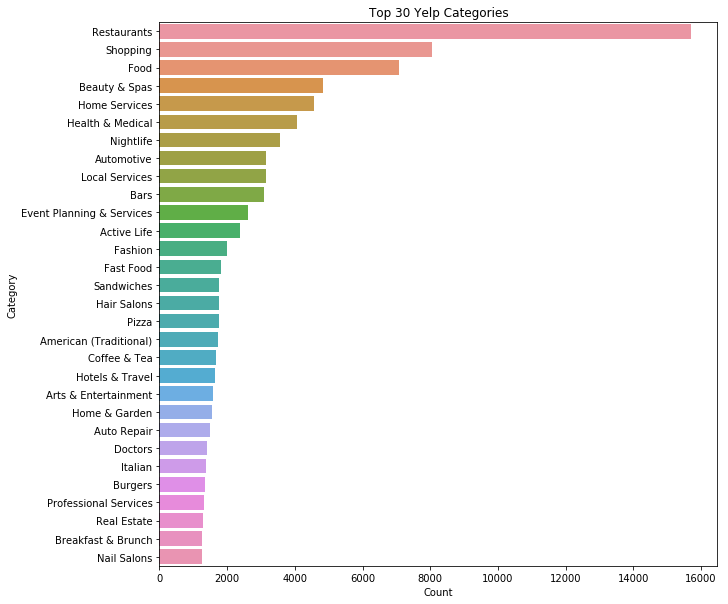

In [18]:
category_counts = business_df.iloc[:, categories_start:categories_end].sum()
category_counts.sort_values(inplace=True, ascending=False)
category_counts_df = pd.DataFrame([category_counts])

plt.figure(figsize=(10,10))
f = sns.barplot(data=category_counts_df.iloc[:, 0:30], orient='h')
f.set_ylabel('Category')
f.set_xlabel('Count')
f.set_title('Top 30 Yelp Categories')

### Analyze Attributes

Text(0.5,1,'Top 30 Yelp Business Attributes')

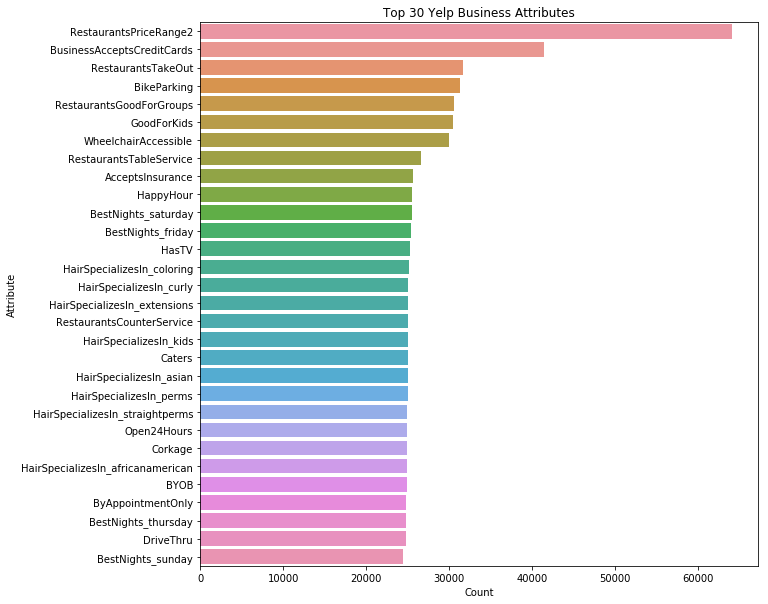

In [17]:
attribute_counts = business_df.iloc[:, attributes_start:attributes_end].sum()
attribute_counts.sort_values(inplace=True, ascending=False)
attribute_counts_df = pd.DataFrame([attribute_counts])

attribute_counts_df.head()

plt.figure(figsize=(10,10))
f = sns.barplot(data=attribute_counts_df.iloc[:, 0:30], orient='h')
f.set_ylabel('Attribute')
f.set_xlabel('Count')
f.set_title('Top 30 Yelp Business Attributes')

In [8]:
# Examples!
print('There are ' + str(len(business_df[business_df['Music_live']==1])) + ' businesses with live music.')
print('There are ' + str(len(business_df[business_df['Smoking_yes']==1])) + ' businesses that allow smoking.')
print('There are ' + str(len(business_df[business_df['GoodForKids']==1])) + ' businesses that are good for kids.')

There are 437 businesses with live music.
There are 356 businesses that allow smoking.
There are 14280 businesses that are good for kids.


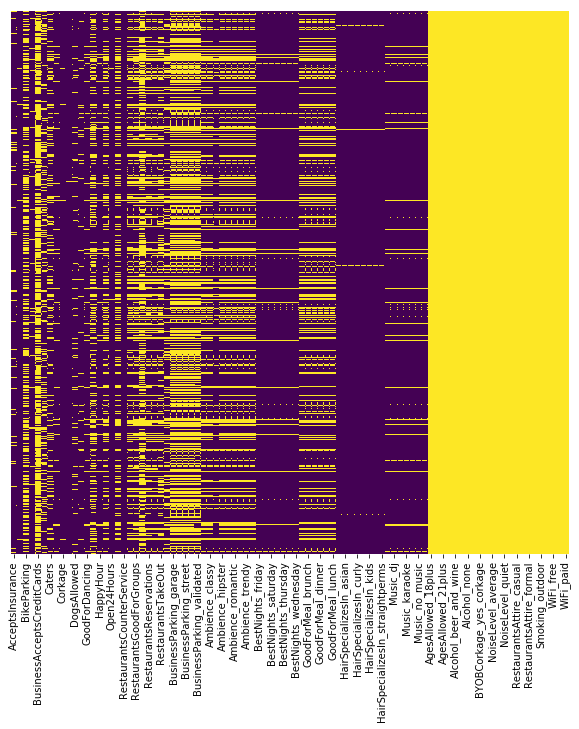

In [13]:
# Attributes heatmap
plt.figure(figsize=(10,10))
f = sns.heatmap(business_df.iloc[:, attributes_start:attributes_end]!=0.5,yticklabels=False, cbar=False, cmap = 'viridis')

### Correlation Between Attributes
Let's check how attributes are correlated within themselves. 

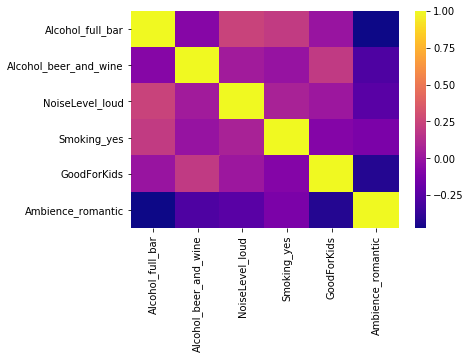

In [134]:
# Correlation between attributes
corr_df = business_df[['Alcohol_full_bar', 'Alcohol_beer_and_wine','NoiseLevel_loud','Smoking_yes', 'GoodForKids', 'Ambience_romantic']]
sns.heatmap(corr_df.corr(), cmap='plasma');

It seems that 'Alcohol_full_bar' venues are not so romantic, they are loud, and not so good for kids.

### Correlation Between Attributes and Star Rating
Let's analyze what are the most important attributes for a business (that is, attributes that correlate with higher star rating).
Since every business type has different attributes, we'll focus on the top 20 categories separately. Data is sparse, so we'll consider per category only attributes that have 30% non-null values.

In [227]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

categories_for_analysis = list(category_counts_df.columns)[:20]
attributes_names = list(business_df.columns)[attributes_start:attributes_end]

for category in categories_for_analysis:
    print('\n----------------------------------')
    print(category)
    print('----------------------------------')
    print('total of ' + str(len(business_df[business_df[category]==1])) + ' businesses found.')
    X = business_df[business_df[category]==1].iloc[:, attributes_start:attributes_end]
    X = X.apply(lambda x: 0.5 if type(x) == 'dict' else x)
    attr_counts = X[X == 1].count()
    attr_counts = pd.DataFrame(attr_counts)
    attr_counts['attr_col_idx'] = list(range(len(attr_counts)))
    attr_counts.sort_values(by=0,ascending=False, inplace=True)
    attr_counts = attr_counts[attr_counts[0] > len(X) * 0.3]
    print(str(len(attr_counts)) + ' significant attributes found for category.')
    X = X.as_matrix()
    y = business_df[business_df[category]==1].iloc[:, 9].as_matrix().astype('float')
    
    # Filter only attributes with high information
    chosen_attr_names = list(attr_counts.index)
    X = X[:, attr_counts['attr_col_idx']]

    # Even after data pre-processing, some cells contain dict objects due to json malformations - clean them up
    X_floats = np.zeros(X.shape)
    for idx, sample in enumerate(X):
        cleaned_sample = []
        for sub_sample in sample:
            if isinstance(sub_sample, dict):
                cleaned_sample.append(0.5)
            else:
                cleaned_sample.append(sub_sample)

        cleaned_sample = np.asarray(cleaned_sample).astype('float')            
        X_floats[idx, :] = cleaned_sample
    
    X = X_floats
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    
    most_sig_attributes = pd.DataFrame({'Attribute':chosen_attr_names, 'Coefficient':regr.coef_})
    most_sig_attributes = most_sig_attributes.sort_values(by=['Coefficient'], ascending=False)
    
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    print('R squared score: %.2f' % r2_score(y_test, y_pred))
    print(most_sig_attributes.iloc[:10,:])
    
    


----------------------------------
Restaurants
----------------------------------
total of 15703 businesses found.
21 significant attributes found for category.
Mean squared error: 0.59
R squared score: 0.07
                  Attribute  Coefficient
18                   Caters     0.243515
5               BikeParking     0.150293
14     WheelchairAccessible     0.135585
9                   WiFi_no     0.131670
19                WiFi_free     0.107445
13        GoodForMeal_lunch     0.076488
15  RestaurantsReservations     0.076481
6   RestaurantsTableService     0.074569
10   RestaurantsPriceRange2     0.067622
16           OutdoorSeating     0.054603

----------------------------------
Shopping
----------------------------------
total of 8064 businesses found.
4 significant attributes found for category.
Mean squared error: 1.04
R squared score: 0.02
                    Attribute  Coefficient
2        WheelchairAccessible     0.344727
1                 BikeParking     0.176640
0  Busi

7 significant attributes found for category.
Mean squared error: 0.61
R squared score: 0.02
                    Attribute  Coefficient
6        WheelchairAccessible     0.351947
3                 BikeParking     0.329764
4              OutdoorSeating     0.014054
5      RestaurantsPriceRange2    -0.052302
2                   WiFi_free    -0.062957
1          RestaurantsTakeOut    -0.069185
0  BusinessAcceptsCreditCards    -0.190757

----------------------------------
Hotels & Travel
----------------------------------
total of 1636 businesses found.
2 significant attributes found for category.
Mean squared error: 1.10
R squared score: 0.00
                    Attribute  Coefficient
0  BusinessAcceptsCreditCards     0.421759
1                   WiFi_free    -0.171982


It seems that accepting a credit card, having a wheelchair access and bike parking are generally good things for your business. However, the R^2 values re generally low, so correlation isn't very strong.

### Collaborative Filtering - Which User Should I Target?
Let's curate data for collaborative filtering.

In [233]:
# Get top user ID's to narrow down data size
user = pd.read_csv('yelp-dataset/yelp_user.csv')
user = user[user['review_count'] > 400]
top_users = list(user['user_id'])
print('Number of top users (with more than 400 reviews) = ' + str(len(top_users)))
del user

Number of top users (with more than 400 reviews) = 8966


In [408]:
from tqdm import tqdm_notebook

all_business_ids = list(business_df['business_id'])
num_businesses = len(all_business_ids)
num_users = len(top_users)
print('Loading reviews table...')
review = pd.read_csv('yelp-dataset/yelp_review.csv')
print('done.')

# Generate user-business matrix, where entries are:
# * binary matrix = 1 if user rated the business with 4+ stars, and 0 otherwise
# * multi matrix = raw star rating
print('Generating use-business matrix...')
start = time.time()
user_business_mat_binary = np.zeros((num_users, num_businesses), dtype=np.float32)
user_business_mat_multi = np.zeros((num_users, num_businesses), dtype=np.float32)

for user_index, user_id in enumerate(tqdm_notebook(top_users)):
    reviews_for_user = review[review['user_id'] == user_id]
    for row_idx, row in reviews_for_user.iterrows():
        if row['business_id'] in all_business_ids:
            business_index = all_business_ids.index(row['business_id'])
            stars = float(row['stars'])
            user_business_mat_multi[user_index, business_index] = np.float32(stars)
            if stars >= 4:
                user_business_mat_binary[user_index, business_index] = 1
            else:
                user_business_mat_binary[user_index, business_index] = 0

# Free memory
del review
print("Finished in " + str(time.time() - start) + ' seconds.')

Loading reviews table...
done.
Generating use-business matrix...


Finished in 5189.6411962509155 seconds.


In [409]:
# Filter out businesses that have no reviews at all
reviews_per_biz_binary = np.sum(user_business_mat_binary, axis=0)
reviews_per_biz_multi = np.sum(user_business_mat_multi, axis=0)

print('Found ' + str(np.count_nonzero(reviews_per_biz_multi)) + ' businesses with reviews.')
print('Found ' + str(np.count_nonzero(reviews_per_biz_binary)) + ' businesses with 4-5 stars reviews.')

filtered_user_business_mat_binary = np.zeros((num_users, np.count_nonzero(reviews_per_biz_binary)))
filtered_user_business_mat_multi = np.zeros((num_users, np.count_nonzero(reviews_per_biz_multi)))
filtered_businesses_binary = []
filtered_businesses_multi = []
filtered_index_binary = 0
filtered_index_multi = 0

print('Filtering businesses without reviews...')
for biz_index, biz_id in enumerate(tqdm_notebook(all_business_ids)):
    if reviews_per_biz_binary[biz_index] > 0:
        filtered_user_business_mat_binary[:, filtered_index_binary] = user_business_mat_binary[:, biz_index]
        filtered_businesses_binary.append(biz_id)
        filtered_index_binary += 1
    if reviews_per_biz_multi[biz_index] > 0:
        filtered_user_business_mat_multi[:, filtered_index_multi] = user_business_mat_multi[:, biz_index]
        filtered_businesses_multi.append(biz_id)
        filtered_index_multi += 1


Found 22581 businesses with reviews.
Found 17238 businesses with 4-5 stars reviews.
Filtering businesses without reviews...


In [484]:
from surprise import Dataset
from surprise.reader import Reader

ratings_dict_multi = {'itemID': [], 'userID': [], 'rating': []}

print('Populating datasets for collaborative filtering...')

# Star matrix
non_zero_indexes_multi = np.nonzero(filtered_user_business_mat_multi)
num_pos_indexes = len(non_zero_indexes_multi[0])
for idx in tqdm_notebook(range(num_pos_indexes)):
    user_id = top_users[non_zero_indexes_multi[0][idx]]
    biz_id = filtered_businesses_multi[non_zero_indexes_multi[1][idx]]
    rating = filtered_user_business_mat_multi[non_zero_indexes_multi[0][idx], non_zero_indexes_multi[1][idx]]
    ratings_dict_multi['itemID'].append(user_id)
    ratings_dict_multi['userID'].append(biz_id)
    ratings_dict_multi['rating'].append(rating)

df_multi = pd.DataFrame(ratings_dict_multi)
print('Done.')

Populating datasets for collaborative filtering...


Done.


In [487]:
dataset_size = len(df_multi)
heldout_proportion = 0.2
heldout_size = int(dataset_size * heldout_proportion)
print('Data size = ' + str(dataset_size))
print('Heldout size = ' + str(heldout_size))

# Keep heldout
train_df = df_multi[:heldout_size]
heldout_df = df_multi[heldout_size:]

heldout_set = Dataset.load_from_df(heldout_df[['userID', 'itemID', 'rating']], reader=Reader(rating_scale=(1,5)))
train_set = Dataset.load_from_df(train_df[['userID', 'itemID', 'rating']], reader=Reader(rating_scale=(1,5)))



Data size = 113406
Heldout size = 22681


## Collaborative Filtering Model Selection
Here we try several collaborative filtering models.
We test each model using 5-fold cross validation, and measure its performance with RMSE (root mean square of error, the standard for regression problems) and FCP (fraction of concordant pairs, as suggested by Koren & Sill in "Collaborative Filtering on Ordinal User Feedback", 2011). We also measure variance over folds, since smaller variance might suggest better generalization to the heldout set.

In [475]:
from surprise.prediction_algorithms import NormalPredictor, KNNBasic, KNNWithMeans, SVD, SVDpp, NMF, SlopeOne, CoClustering
from surprise.model_selection import cross_validate
cross_validation_results = []

models = [NormalPredictor(), KNNBasic(), KNNWithMeans(), SVD(), SVDpp(), NMF(), SlopeOne(), CoClustering()]
model_names = ['Random', 'KNN Basic', 'KNN+means', 'SVD', 'SVD++', 'NMF', 'SlopeOne', 'Co-Clustering']
for idx, model in tqdm_notebook(enumerate(models)):
    print('@@@ Evaluating model = ' + model_names[idx] + ' @@@')
    res = cross_validate(model, train_set, cv=5, measures=['rmse', 'fcp'])
    cross_validation_results.append(res)
print('Done.')
    

@@@ Evaluating model = Random @@@
@@@ Evaluating model = KNN Basic @@@
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
@@@ Evaluating model = KNN+means @@@
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
@@@ Evaluating model = SVD @@@
@@@ Evaluating model = SVD++ @@@
@@@ Evaluating model = NMF @@@
@@@ Evaluating model = SlopeOne @@@
@@@ Evaluating model = Co-Clust

In [474]:
rmse_means = []
rmse_vars = []
fcp_means = []
fcp_vars = []

for idx, result in enumerate(cross_validation_results):
    rmse_means.append(np.mean(result['test_rmse']))
    rmse_vars.append(np.var(result['test_rmse']))
    fcp_means.append(np.mean(result['test_fcp']))
    fcp_vars.append(np.var(result['test_fcp']))

collab_results_df = pd.DataFrame({'Model':model_names,'RMSE mean':rmse_means, 'RMSE var':rmse_vars, 'FCP mean':fcp_means, 'FCP var':fcp_vars})
collab_results_df = collab_results_df[['Model', 'RMSE mean', 'RMSE var', 'FCP mean', 'FCP var']].sort_values(by='RMSE mean')
print(collab_results_df)

           Model  RMSE mean  RMSE var  FCP mean   FCP var
3            SVD   0.981460  0.000206  0.505305  0.000029
4          SVD++   0.983146  0.000074  0.509970  0.000474
1      KNN Basic   1.086229  0.000254  0.557916  0.000116
7  Co-Clustering   1.091213  0.000091  0.531447  0.000220
2      KNN+means   1.095805  0.000159  0.573819  0.000261
6       SlopeOne   1.128169  0.000238  0.578748  0.000083
5            NMF   1.132722  0.000165  0.547838  0.000241
0         Random   1.400291  0.000080  0.498035  0.000350


Clearly, the SVD model (a.k.a. Netflix Prize) has the best RMSE score, but SlopeOne has the best FCP (in the FCP score, higher is better). How should we choose?

In [482]:
from surprise.accuracy import rmse, fcp

model_svd = models[3]
model_slopeone = models[6]

full_train_set = train_set.build_full_trainset()
full_heldout_set = heldout_set.build_full_trainset().build_testset()

model_svd.fit(full_train_set)
model_slopeone.fit(full_train_set)

preds_svd = model_svd.test(full_heldout_set)
preds_slopeone = model_slopeone.test(full_heldout_set)
print(' --- SVD ---')
rmse(preds_svd)
fcp(preds_svd)
print(' --- SlopeOne ---')
rmse(preds_slopeone)
fcp(preds_slopeone)



 --- SVD ---
RMSE: 0.9921
FCP:  0.1520
 --- SlopeOne ---
RMSE: 1.0238
FCP:  0.1520


0.15201013729743312

Turns out, SVD outperforms SlopeOne on the heldout set. So this is the chosen model.

### Alternative Metrics
If you can't improve the model, improve the metrics! :)
Since we're only interested in locating users that will give us high star rating, let's binarize the evaluation: set a threshold (say, 4 stars), and assign correct hit if both predicted score and true star rating were >= 4. Here we evaluated two thresholds - 3 and 4.

In [514]:
def eval_model_on_heldout(trained_model):
    thresh_3_correct = 0
    thresh_3_incorrect = 0
    thresh_4_correct = 0
    thresh_4_incorrect = 0

    for row_idx, row in heldout_df.iterrows():
        uid = row['userID']
        iid = row['itemID']
        gt_stars = row['rating']  # ground truth
        prediction = trained_model.predict(uid, iid, clip=True).est
        if gt_stars >= 3 and prediction >= 3:
            thresh_3_correct += 1
        elif gt_stars < 3 and prediction < 3:
            thresh_3_correct += 1
        else:
            thresh_3_incorrect +=1

        if gt_stars >= 4 and prediction >= 4:
            thresh_4_correct += 1
        elif gt_stars < 4 and prediction < 4:
            thresh_4_correct += 1
        else:
            thresh_4_incorrect += 1

    print('Accuracy using threshold 3 = ' + str(thresh_3_correct / (thresh_3_correct + thresh_3_incorrect)))
    print('Accuracy using threshold 4 = ' + str(thresh_4_correct / (thresh_4_correct + thresh_4_incorrect)))

eval_model_on_heldout(model_svd)

Accuracy using threshold 3 = 0.8719867732157619
Accuracy using threshold 4 = 0.42465693028382473


So we have a 42% chance of correctly predicting a user rating, in a binary scale of high (4-5 stars) vs. low (1-3 stars). What if we also binarize training data?

In [501]:
binary_train_df = train_df.copy()
binary_train_df['rating'] = binary_train_df['rating'].replace([1.0, 2.0, 3.0], 1)
binary_train_df['rating'] = binary_train_df['rating'].replace([4.0, 5.0], 5)
train_set_binary = Dataset.load_from_df(train_df[['userID', 'itemID', 'rating']], reader=Reader(rating_scale=(1,5)))

In [505]:
models_binary = [NormalPredictor(), KNNBasic(), KNNWithMeans(), SVD(), SVDpp(), NMF(), SlopeOne(), CoClustering()]
cross_validation_results = []
for idx, model in tqdm_notebook(enumerate(models_binary)):
    print('@@@ Evaluating model = ' + model_names[idx] + ' @@@')
    res = cross_validate(model, train_set_binary, cv=5, measures=['rmse', 'fcp'])
    cross_validation_results.append(res)
print('Done.')

rmse_means = []
rmse_vars = []
fcp_means = []
fcp_vars = []

for idx, result in enumerate(cross_validation_results):
    rmse_means.append(np.mean(result['test_rmse']))
    rmse_vars.append(np.var(result['test_rmse']))
    fcp_means.append(np.mean(result['test_fcp']))
    fcp_vars.append(np.var(result['test_fcp']))

collab_results_df = pd.DataFrame({'Model':model_names,'RMSE mean':rmse_means, 'RMSE var':rmse_vars, 'FCP mean':fcp_means, 'FCP var':fcp_vars})
collab_results_df = collab_results_df[['Model', 'RMSE mean', 'RMSE var', 'FCP mean', 'FCP var']].sort_values(by='RMSE mean')
print(collab_results_df)

@@@ Evaluating model = Random @@@
@@@ Evaluating model = KNN Basic @@@
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
@@@ Evaluating model = KNN+means @@@
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
@@@ Evaluating model = SVD @@@
@@@ Evaluating model = SVD++ @@@
@@@ Evaluating model = NMF @@@
@@@ Evaluating model = SlopeOne @@@
@@@ Evaluating model = Co-Clust

In [515]:
model_svdpp_binary = models_binary[4]
eval_model_on_heldout(model_svdpp_binary)

Accuracy using threshold 3 = 0.8730559382750069
Accuracy using threshold 4 = 0.43434554973821987


Results are improved on the heldout set! from 42.47% to 43.43% when splitting star ratings into 12 vs. 345, and from 87.20% to 87.31% when splitting star ratings into 123 vs. 45. We conclude that in our use-case of predicting high rating from a user, transforming the training data into two classes (instead of 5) yields better results. Next step - refine parameters witha grid search.

In [510]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors':[20, 40, 100], 
              'n_epochs':[20, 30], 
              'lr_all': [0.002, 0.005, 0.007], 
              'reg_all': [0.02, 0.04]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae', 'fcp'], cv=3)
gs.fit(train_set_binary)


In [512]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9824569465255476
{'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.04}


In [513]:
print(gs.best_score['fcp'])
print(gs.best_params['fcp'])

0.5149381198320596
{'n_factors': 40, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.04}


In [519]:
model_svdpp_binary_best_params = SVDpp(n_factors=40, n_epochs=20, lr_all=0.005, reg_all=0.04)
model_svdpp_binary_best_params.fit(train_set_binary.build_full_trainset())
eval_model_on_heldout(model_svdpp_binary_best_params)

Accuracy using threshold 3 = 0.8711600992008818
Accuracy using threshold 4 = 0.4263764122347754


We conclude that training and SVDpp model with the params we found using grid search did not improve results.

### Collaborative Filtering - Alternative Similarity Methods
We implemented collaborative filtering based on user-item matrices (user-business in our case) using cosine, jaccard and pearson similarity to predict a restaurant review by a given user, based on the user similarity to other users who reviewed the chosen restaurant.

In order to make our data easier to process, we decided to focus on restaurants that serve Pizza in Las-Vegas (simply because Vegas has the most Pizza places in the Yelp database... ).

After creating the similarity matrices between all the users in our db, based on the different similarity functions, we used KNN in order to predict the number of stars the chosen user will give to the restaurant.

In the upcoming part, we also used sqlite db and loaded all the data into it, we found out that in some cases it is much easier (and sometimes faster) to work with.
The db is saved in the file yelp.db, which is way to big to be included in our repository (6GB).
Also, we dumped most of the data using pickle to save time.

In [3]:
# Imports and loading of pickle files.
# In order to create those files,
# the block with the matrices creation should contain all the dumping functions
import sqlite3
import numpy as np
import scipy.spatial
from scipy.sparse import *
import scipy.stats
import pickle
import time
import math
import random

connection = sqlite3.connect("yelp.db")
cursor = connection.cursor()

users_dict = pickle.load(open('users_ids_dict', 'rb'))
user_similarity_cosine = pickle.load(open('user_similarity_cosine_matrix', 'rb'))
user_similarity_jaccard = pickle.load(open('user_similarity_jaccard_matrix', 'rb'))
user_similarity_pearson = pickle.load(open('user_similarity_pearson_matrix', 'rb'))
test = pickle.load(open('user_similarity_test_reviews', 'rb'))

Data was split to train and test sets by 80-20, and shuffled.

In [4]:
def split_train_test():
    reviews = cursor.execute('SELECT business_id,user_id,stars,useful FROM review').fetchall()

    random.shuffle(reviews)

    # split to train-test by 80-20
    train = reviews[: int(len(reviews) * .80)]
    test = reviews[int(len(reviews) * .80):]

    return train, test

Creating the users similarity matrices, based on cosine, Jaccard and Pearson similarity measures.
For each user, we calculate the similarity with every other user based on how the users rated all the restaurants, calculated with the similarity measures, we get the similarity between user i and user j in the cell (i,j) in the similarity matrix.

We created three different matrices, one for each similarity measure in order to see which on of them will be the most accurate.

In [5]:
def create_user_similarity_matrices(reviews):
    users = cursor.execute('SELECT user_id FROM user ORDER BY user_id').fetchall()
    businesses = cursor.execute('SELECT id FROM business').fetchall()

    # create empty matrices
    user_business_matrix = np.zeros((len(users), len(businesses)))
    user_similarity_cosine = np.zeros((len(users), len(users)))
    user_similarity_jaccard = np.zeros((len(users), len(users)))
    user_similarity_pearson = np.zeros((len(users), len(users)))

    # save business and user ids in dictionaries for later use
    users_ids = dict()
    businesses_ids = dict()
    for i in range(len(users)):
        users_ids[users[i][0]] = i

    for i in range(len(businesses)):
        businesses_ids[businesses[i][0]] = i

    pickle.dump(users_ids, open('users_ids_dict', 'wb'))
    pickle.dump(businesses_ids, open('businnesses_ids_dict', 'wb'))

    # adding rating to the matrix
    for review in reviews:
        user_id = users_ids[review[1]]
        business_id = businesses_ids[review[0]]
        user_business_matrix[user_id][business_id] = review[2]

    pickle.dump(user_business_matrix, open('user_business_matrix', 'wb'))

    print('Number of users:', len(users))
    print('Number of reviews:', len(reviews))
    start = time.time()

    # create similarity matrices using cosine,jaccard and pearson similarity
    for user1 in users_ids.keys():
        user1_id = users_ids[user1]

        for user2 in users_ids.keys():
            user2_id = users_ids[user2]
            if np.count_nonzero(user_business_matrix[user1_id]) and np.count_nonzero(user_business_matrix[user2_id]):
                user_similarity_cosine[user1_id][user2_id] = 1 - scipy.spatial.distance.cosine(
                    user_business_matrix[user1_id],
                    user_business_matrix[user2_id])
                user_similarity_jaccard[user1_id][user2_id] = 1 - scipy.spatial.distance.jaccard(
                    user_business_matrix[user1_id],
                    user_business_matrix[user2_id])
                try:
                    if not math.isnan(
                            scipy.stats.pearsonr(user_business_matrix[user1_id], user_business_matrix[user2_id])[0]):
                        user_similarity_pearson[user1_id][user2_id] = \
                            scipy.stats.pearsonr(user_business_matrix[user1_id], user_business_matrix[user2_id])[0]
                    else:
                        user_similarity_pearson[user1_id][user2_id] = 0
                except:
                    user_similarity_pearson[user1_id][user2_id] = 0

    return user_similarity_cosine, user_similarity_jaccard, user_similarity_pearson


We used KNN in order to predict the rating: given a review from the test set, we try to predict its rating.
We average the review of the top K similar users, with K of 3, 5 and 7.
This average is rounder up or down as needed.
We measure ourselves with accuracy- a difference of more than 1 stars was considered an error.

In [6]:
def prediction(matrix, k, review):
    top_k_users = []

    business_reviews = cursor.execute(
        '''SELECT business_id,user_id,stars,useful FROM review where business_id='{0}' '''.format(review[0])).fetchall()
    review_users = [review[:3] for review in business_reviews]

    # get chosen user data ( user from given review )
    user_index = users_dict[review[1]]
    users_matrix_col = matrix[user_index]

    # find matrix row index for each user that reviewed this business
    similar_users = []
    for user in review_users:
        if user[1] in users_dict.keys():
            similar_users.append((users_dict[user[1]], user[2]))

    # get rating for each index and argsort
    similar_users_similarity = []
    for user in similar_users:
        similar_users_similarity.append(users_matrix_col[user[0]])
    top_k_indexes = np.argsort(similar_users_similarity)[-(k + 1):][::-1]

    # Not enough users that reviewed this business...
    if len(top_k_indexes) <= k:
        return 0

    for i in range(1, k + 1):
        user = similar_users[top_k_indexes[i]]
        top_k_users.append(user)

    # try to predict review by average all K users rating
    sum = 0
    for i in range(k):
        rating = top_k_users[i][1]
        sum += rating

    sum = sum / k
    diff = sum - math.floor(sum)
    if diff >= 0.5:
        sum = int(sum + (1 - diff))
    else:
        sum = int(math.floor(sum))

    return sum


In [7]:
def knn(k):
    cosine_error = 0
    jaccard_error = 0
    pearson_error = 0
    
    # if review has less than k u
    invalid_reviews_cosine=0
    invalid_reviews_jaccard=0
    invalid_reviews_pearson=0

    for review in test:
       
        pred_cosine = prediction(user_similarity_cosine, k, review)
        pred_jaccard = prediction(user_similarity_jaccard, k, review)
        pred_pearson = prediction(user_similarity_pearson, k, review)
        
        if pred_cosine==0:
            invalid_reviews_cosine+=1  
        elif abs(review[2] - pred_cosine) > 1:
            cosine_error += 1
        
        if pred_jaccard==0:
            invalid_reviews_jaccard+=1
        elif abs(review[2] - pred_jaccard) > 1:
            jaccard_error += 1
        
        if pred_pearson==0:
            invalid_reviews_pearson+=1
        elif abs(review[2] - pred_pearson) > 1:
            pearson_error += 1

    return cosine_error / (len(test)-invalid_reviews_cosine), jaccard_error / (len(test)-invalid_reviews_jaccard), pearson_error / (len(test)-invalid_reviews_pearson)


In [16]:
# Main
error = 0

cosine_3, jaccard_3, pearson_3 = knn(3)
cosine_5, jaccard_5, pearson_5 = knn(5)
cosine_7, jaccard_7, pearson_7 = knn(7)

print('K=3:')
print('Cosine Accuracy (%)', round(1 - cosine_3,4))
print('Jaccard Accuracy (%)', round(1 - jaccard_3,4))
print('Pearson Accuracy (%)', round(1 - pearson_3,4))
print('K=5:')
print('Cosine Accuracy (%)', round(1 - cosine_5,4))
print('Jaccard Accuracy (%)', round(1 - jaccard_5,4))
print('Pearson Accuracy (%)', round(1 - pearson_5,4))
print('K=7:')
print('Cosine Accuracy (%)', round(1 - cosine_7,4))
print('Jaccard Accuracy (%)', round(1 - jaccard_7,4))
print('Pearson Accuracy (%)', round(1 - pearson_7,4))


K=3:
Cosine Accuracy (%) 0.7897
Jaccard Accuracy (%) 0.7897
Pearson Accuracy (%) 0.7844
K=5:
Cosine Accuracy (%) 0.8252
Jaccard Accuracy (%) 0.8204
Pearson Accuracy (%) 0.8216
K=7:
Cosine Accuracy (%) 0.8437
Jaccard Accuracy (%) 0.8404
Pearson Accuracy (%) 0.8401


Based on the results, we can see that similarity measures gives us almost the same results in terms of accuracy, altough, where K=7, we get the best results using Cosine similarity.

In [ ]:
# Run this block to create all the neede pickle files (train-tests and similarity matrices)

# train, test = split_train_test()
# cosine, jaccard, pearson = create_user_similarity_matrices(train)
# pickle.dump(cosine, open('user_similarity_cosine_matrix', 'wb'))
# pickle.dump(jaccard, open('user_similarity_jaccard_matrix', 'wb'))
# pickle.dump(pearson, open('user_similarity_pearson_matrix', 'wb'))
# pickle.dump(test, open('user_similarity_test_reviews', 'wb'))


### NLP - Using Business/Business Similarity Matrix
We also tried using a business/business similarity matrix in the following way: let's say we want to predict how a user will rate us. We search among the other businesses this user rated for the one which is most similar to ours, and hypothesize that the user will rate our business similarly.
Similarity between two businesses was determined by concatenating the reviews of each business into a single text document, and then measuring text similarity between the two texts by TF-IDF (after stemming).


In [ ]:
# Generating business/business similarity matrix
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import pickle

stemmer = SnowballStemmer("english")

def load_business_ids(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    return [line.strip()[1:-1] for line in lines]


def process_review(review):
    review = stemmer.stem(review)
    return review


def load_reviews(filename, limit_set=None, limit=100, process_func=None):
    # Load data
    reviews = {}
    line_count = 0
    print('Loading reviews...')
    with open(filename, 'r', encoding='utf8') as f:
        for line in f:
            if limit is None or line_count < limit:
                business_id = json.loads(line)['business_id']
                if limit_set is not None and business_id not in limit_set:
                    continue
                review_text = json.loads(line)['text']
                if process_func is not None:
                    review_text = process_func(review_text)

                if business_id in reviews:
                    reviews[business_id] = reviews[business_id] + ' ' + review_text
                else:
                    reviews[business_id] = review_text
                line_count += 1
            else:
                break
    result = []
    if limit_set is None:
        keys = list(reviews.keys())
    else:
        keys = list(limit_set)

    for business_id in keys:
        result.append(reviews[business_id])
    return result


def build_sim_mat_tfidf(reviews):
    from sklearn.feature_extraction.text import TfidfVectorizer
    vect = TfidfVectorizer(min_df=1)
    tfidf = vect.fit_transform(reviews)
    return tfidf * tfidf.T

# We limit ourselves to a subset of businesses, for performance issues
limited_set_ids = load_business_ids('businessIDs.txt')

loaded_reviews = load_reviews('yelp-dataset/review.json', limit_set=limit_set_ids, limit=None, process_func=process_review)
sim_mat_tfidf = build_sim_mat_tfidf(loaded_reviews)


We use the businesses similarity matrix to predict a business rating, based on its similarity to another business.
For every business, we take the most similar business, and our prediction is the avg. rating of all the users who reviewed the given business and the most similar one. If no users reviewed both, we take the second most similar and so on, until we find a similar business with users who reviewed both of the businesses.

We used two evaluation metrics:
    1. Accuracy - if the prediction and the actual rating are different by more than 0.5, than we count it as an error. Otherwise, a hit.
    2. Binary Accuracy - if the prediction and the actual rating are both on the same side of a threshold (3.5), or are equal - this is a hit. Otherwise, an error.
    

In [15]:
import pickle
import sqlite3
import numpy as np

connection = sqlite3.connect("yelp.db")
cursor = connection.cursor()

matrix = pickle.load(open('sim_mat_tfidf.pkl', 'rb')).toarray()

businesses = cursor.execute('SELECT id,stars FROM business').fetchall()

def find_users_reviewed_business(business_index):
    # Find similar business
    row = matrix[business_index]
    sorted_similarity = np.argsort(row)
    similar_index = 0
    business_id = businesses[business_index][0]
    similar_business_id = businesses[sorted_similarity[similar_index]][0]

    users = []

    # If no users found, go to the second most similar business and try again
    while len(users) == 0 and similar_index < len(businesses) - 1:
        similar_index += 1
        similar_business_id = businesses[sorted_similarity[similar_index]][0]

        # Find all users that reviewed both businesses
        data = cursor.execute('''SELECT user_id from review where business_id='{0}'
                                      intersect
                                      SELECT user_id from review where business_id='{1}' '''
                              .format(business_id, similar_business_id)).fetchall()
        users = [user[0] for user in data]
    
    # not enough users that reviewd both businesses
    if len(users) == 0:
        return -1
    avg_stars = cursor.execute('''select avg(stars) from review where business_id='{0}' and user_id in ({1}) '''
                               .format(similar_business_id,
                                       ', '.join("'{0}'".format(w) for w in users))).fetchone()[0]
    # round prediction to .5 or .0
    avg_stars = round(avg_stars * 2) / 2
    
    # bad prediction
    if abs(avg_stars - float(businesses[business_index][1])) > 0.5:
        return 1
    return 0

# Main
err = 0
results = []
# bussinesses that we could not find any similar business with users who reviewed both
not_enough_users_count = 0

for index in range(len(businesses)):
    results.append(find_users_reviewed_business(index))
    if results[index] > 0:
        err += 1
    if results[index] == -1:
        not_enough_users_count+=1

err = err / (len(businesses)-not_enough_users_count)

pickle.dump(results, open('results', 'wb'))
print("Accuracy:", 1 - err)

threshold_count = 0
total = 0
for index in range(len(businesses)):
    if results[index] == businesses[index][1] or (results[index] > 3.5 and businesses[index][1] > 3.5) or (
                    results[index] < 3.5 and businesses[index][1] < 3.5):
        threshold_count += 1
    if results[index] > 0:
        total+=1
print("Binary Accuracy:", threshold_count / total)


Accuracy: 0.4175627240143369
Binary Accuracy: 0.796923076923077


We conclude that using TF-IDF based similarity matrix, gives us kind of poor results in terms of accuracy, but using binary accuracy shows us results similar to the previous results shown in the Collaborative filtering using cosine/jaccard/pearson similarities.